In [1]:
from graphdatascience import GraphDataScience
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

This notebook was run with a free Neo4j sandbox. To run it yourself, log in to https://sandbox.neo4j.com and launch the "Data Science" project. Then, copy the connection information from your sandbox into the cell below.

In [2]:
gds = GraphDataScience("bolt://3.83.87.20:7687", auth=('neo4j', 'hunk-flange-smells'))
gds.set_database("neo4j")

# Discover communities

This section of the notebook was run before the session.

Project a graph of airports and HAS_ROUTE relationships.

In [3]:
G_air, results = gds.graph.project("air-routes", "Airport", 
                                   {"HAS_ROUTE": {"orientation": "UNDIRECTED"}})

In [4]:
results

nodeProjection            {'Airport': {'label': 'Airport', 'properties':...
relationshipProjection    {'HAS_ROUTE': {'orientation': 'UNDIRECTED', 'a...
graphName                                                        air-routes
nodeCount                                                              3503
relationshipCount                                                     92778
projectMillis                                                          2195
Name: 0, dtype: object

Check the count of weakly connected components. Weakly connected components are communities within the graph where all nodes in within the same component are connected by paths.

In [5]:
gds.wcc.stats(G_air)['componentDistribution']

{'p99': 1,
 'min': 1,
 'max': 3292,
 'mean': 16.52358490566038,
 'p90': 1,
 'p50': 1,
 'p999': 3292,
 'p95': 1,
 'p75': 1}

It looks like there are a lot of components of size 1. Let's make a subgraph that just has the giant connected component.

In [7]:
gds.wcc.mutate(G_air, mutateProperty = "wccComponent")

mutateMillis                                                            65
nodePropertiesWritten                                                 3503
componentCount                                                         212
componentDistribution    {'p99': 1, 'min': 1, 'max': 3292, 'mean': 16.5...
postProcessingMillis                                                     7
preProcessingMillis                                                      0
computeMillis                                                           36
configuration            {'seedProperty': None, 'consecutiveIds': False...
Name: 0, dtype: object

In [8]:
component_df = gds.graph.streamNodeProperty(G_air, "wccComponent")

Find the component that has the most nodes.

In [9]:
component_df.value_counts('propertyValue').sort_values(ascending=False)

propertyValue
0       3292
3013       1
2993       1
472        1
941        1
        ... 
3479       1
3480       1
3481       1
3483       1
3490       1
Length: 212, dtype: int64

Record the component ids in the persistent graph on disk.

In [10]:
gds.graph.writeNodeProperties(G_air, ["wccComponent"])

writeMillis                    3975
graphName                air-routes
nodeProperties       [wccComponent]
propertiesWritten              3503
Name: 0, dtype: object

Create a subgraph that has only the connected airports.

In [11]:
G_connected, result = gds.beta.graph.project.subgraph("connected-airports", 
                                                       G_air, 
                                                       f"n.wccComponent = 0", 
                                                       "*")

In [12]:
result

fromGraphName                 air-routes
nodeFilter            n.wccComponent = 0
relationshipFilter                     *
graphName             connected-airports
nodeCount                           3292
relationshipCount                  92778
projectMillis                       2127
Name: 0, dtype: object

Create communities with the Louvain algorithm.

In [13]:
gds.louvain.write(G_connected, writeProperty = "louvainCommunity")

writeMillis                                                           2109
nodePropertiesWritten                                                 3292
modularity                                                         0.59464
modularities             [0.5783615229548567, 0.5941470321783298, 0.594...
ranLevels                                                                3
communityCount                                                          22
communityDistribution    {'p99': 774, 'min': 2, 'max': 774, 'mean': 149...
postProcessingMillis                                                     6
preProcessingMillis                                                      0
computeMillis                                                         7193
configuration            {'maxIterations': 10, 'writeConcurrency': 4, '...
Name: 0, dtype: object

Create communities with the label propagation algorithm.

In [14]:
gds.labelPropagation.write(G_connected, writeProperty = "labelPropCommunity")

writeMillis                                                            709
nodePropertiesWritten                                                 3292
ranIterations                                                            3
didConverge                                                           True
communityCount                                                           2
communityDistribution    {'p99': 3193, 'min': 99, 'max': 3193, 'mean': ...
postProcessingMillis                                                   290
preProcessingMillis                                                      0
computeMillis                                                         1474
configuration            {'maxIterations': 10, 'writeConcurrency': 4, '...
Name: 0, dtype: object

K-Means isn't available in the sandboxes yet, so let's get the embeddings and calculate K-Means in Python.

In [15]:
embedding_df = gds.fastRP.stream(G_connected, embeddingDimension=64)

In [16]:
kmeans = KMeans(n_clusters = 6)

In [17]:
kmeans_clusters = kmeans.fit_transform(list(embedding_df['embedding']))

In [18]:
embedding_df['cluster'] = kmeans.labels_

How many nodes ended up in each cluster?

In [19]:
embedding_df['cluster'].value_counts()

5    741
4    649
3    622
1    604
2    393
0    283
Name: cluster, dtype: int64

What is the silhouette score for the k-means clusters?

In [20]:
silhouette_score(list(embedding_df['embedding']), embedding_df['cluster'])

0.2533216279346602

Write the K-Means clusters back to Neo4j. Turn the dataframe into a list of dictionaries.

In [21]:
kmeans_dict = embedding_df[['nodeId', 'cluster']].to_dict("records")

Pass the list of dictionaries as a parameter to a Cypher query.

In [22]:
gds.run_cypher("""
UNWIND $kmeansAssigments as row
MATCH (n) where id(n) = row['nodeId']
SET n.kMeansCommunity = row['cluster']
""", {"kmeansAssigments": kmeans_dict})

""


Drop the old graph projections.

In [23]:
gds.graph.drop(G_air)
gds.graph.drop(G_connected)

graphName                                           connected-airports
database                                                         neo4j
memoryUsage                                                           
sizeInBytes                                                         -1
nodeCount                                                         3292
relationshipCount                                                92778
configuration        {'relationshipProjection': {'HAS_ROUTE': {'ori...
density                                                       0.008564
creationTime                       2022-06-01T18:45:43.969411000+00:00
modificationTime                   2022-06-01T18:45:46.097020000+00:00
schema               {'relationships': {'HAS_ROUTE': {}}, 'nodes': ...
Name: 0, dtype: object

Create a new graph projection that contains only connected airports and includes all three of our community ids as node properties.

Start by adding a new ConnectedAirport label to airports in component 0.

In [24]:
gds.run_cypher("""MATCH (a:Airport {wccComponent:0}) SET a:ConnectedAirport RETURN count(a) as airportCount""")

,airportCount
0,3292


Create the new projection.

In [25]:
G_air, results = gds.graph.project("air-routes", 
                                   {"ConnectedAirport": 
                                        {"properties": ["louvainCommunity", "labelPropCommunity", "kMeansCommunity"]}}, 
                                   {"HAS_ROUTE": {"orientation": "UNDIRECTED"}})

Create a dataframe with the node counts for each community.

In [26]:
community_df = gds.graph.streamNodeProperties(G_air, ["louvainCommunity", "labelPropCommunity", "kMeansCommunity"])
community_df = community_df.groupby(['nodeProperty', 'propertyValue']).count()
community_df.reset_index(inplace=True)
community_df.rename({"nodeProperty": "community_property", "propertyValue": "community", "nodeId":"node_count"}, 
                    axis=1, inplace=True)

In [27]:
community_df

,community_property,community,node_count
0,kMeansCommunity,0,283
1,kMeansCommunity,1,604
2,kMeansCommunity,2,393
3,kMeansCommunity,3,622
4,kMeansCommunity,4,649
5,kMeansCommunity,5,741
6,labelPropCommunity,8629,3193
7,labelPropCommunity,8634,99
8,louvainCommunity,65,271
9,louvainCommunity,810,178


Write a function to create a subgraph for a community property. 

In [28]:
def create_subgraph(community_property, community_id):
    subgraph_name = f"{community_property}_{community_id}"
    subgraph_filter = f"n.{community_property} = {community_id}"
    subgraph, result = gds.beta.graph.project.subgraph(subgraph_name, 
                                                       G_air,
                                                       subgraph_filter, 
                                                       "*")
    return subgraph

Run the function for each row in the community_df data frame.

In [29]:
community_df['subgraph'] = community_df.apply(lambda row: 
                                              create_subgraph(row['community_property'], row['community']),
                                              axis=1)  

# Setup complete
Before the session, I created communities from a graph of airports and air routes. The dataframe below contains the community property, community ID, and a node count for each community in the graph. It also contains a column which holds a python graph object for each community.

In [30]:
community_df

,community_property,community,node_count,subgraph
0,kMeansCommunity,0,283,<graphdatascience.graph.graph_object.Graph obj...
1,kMeansCommunity,1,604,<graphdatascience.graph.graph_object.Graph obj...
2,kMeansCommunity,2,393,<graphdatascience.graph.graph_object.Graph obj...
3,kMeansCommunity,3,622,<graphdatascience.graph.graph_object.Graph obj...
4,kMeansCommunity,4,649,<graphdatascience.graph.graph_object.Graph obj...
5,kMeansCommunity,5,741,<graphdatascience.graph.graph_object.Graph obj...
6,labelPropCommunity,8629,3193,<graphdatascience.graph.graph_object.Graph obj...
7,labelPropCommunity,8634,99,<graphdatascience.graph.graph_object.Graph obj...
8,louvainCommunity,65,271,<graphdatascience.graph.graph_object.Graph obj...
9,louvainCommunity,810,178,<graphdatascience.graph.graph_object.Graph obj...


# Conductance
What percentage of relationships that start in one cluster end in a different cluster?

Call the conductance algorithm for each community property in G_air and collect the results.

In [1]:
community_properties = ['louvainCommunity', 'labelPropCommunity', 'kMeansCommunity']

In [32]:
conductance_dfs = []
for prop in community_properties:
    conductance_df = gds.alpha.conductance.stream(G_air, communityProperty=prop)
    conductance_df['community_property'] = prop
    conductance_dfs.append(conductance_df)
conductance_df = pd.concat(conductance_dfs)

In [33]:
conductance_df

,community,conductance,community_property
0,65,0.168021,louvainCommunity
1,810,0.435606,louvainCommunity
2,1093,0.125000,louvainCommunity
3,1097,0.212121,louvainCommunity
4,1098,0.250000,louvainCommunity
5,1100,0.073171,louvainCommunity
6,1104,0.151515,louvainCommunity
7,1106,0.250000,louvainCommunity
8,1108,0.085714,louvainCommunity
9,1182,0.290273,louvainCommunity


In [34]:
community_df = community_df.merge(conductance_df, on=['community_property', 'community'])

Plot the conductance versus the node count for each community. It seems that the largest communities are big enough to be mostly self-contained, while the smaller communities have a range of conductance scores.

<AxesSubplot:xlabel='node_count', ylabel='conductance'>

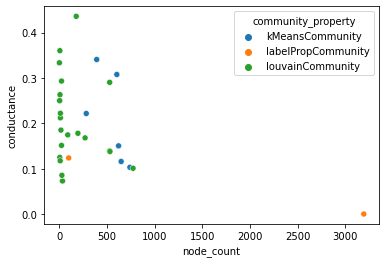

In [35]:
sns.scatterplot(x="node_count", y="conductance", hue="community_property", data=community_df)

# Modularity
What is the difference between the fraction of within-cluster relationships that we observe versus what we would see if nodes kept the same degree, but the relationships were connected randomly? We can calculate this for the Louvain communities, but there's not a quick way to calculate it for the others.

In [36]:
gds.louvain.stats(G_air)

modularity                                                        0.595428
modularities             [0.570002504499057, 0.5949092827603943, 0.5954...
ranLevels                                                                3
communityCount                                                          21
communityDistribution    {'p99': 803, 'min': 2, 'max': 803, 'mean': 156...
postProcessingMillis                                                     3
preProcessingMillis                                                      0
computeMillis                                                         4162
configuration            {'maxIterations': 10, 'seedProperty': None, 'c...
Name: 0, dtype: object

# Clustering Coefficient
What is the probability that two neighbors of a node also have a relationship between them?

Call the localClusteringCoefficient algorithm for each subgraph in the community_df data frame.

In [37]:
community_df['average_clustering_coefficient'] = (
    community_df['subgraph'].map(lambda x: gds.localClusteringCoefficient.stats(x)['averageClusteringCoefficient']))

In [38]:
community_df

,community_property,community,node_count,subgraph,conductance,average_clustering_coefficient
0,kMeansCommunity,0,283,<graphdatascience.graph.graph_object.Graph obj...,0.221711,0.376070
1,kMeansCommunity,1,604,<graphdatascience.graph.graph_object.Graph obj...,0.307613,0.202911
2,kMeansCommunity,2,393,<graphdatascience.graph.graph_object.Graph obj...,0.340567,0.479081
3,kMeansCommunity,3,622,<graphdatascience.graph.graph_object.Graph obj...,0.150480,0.535675
4,kMeansCommunity,4,649,<graphdatascience.graph.graph_object.Graph obj...,0.116055,0.567970
5,kMeansCommunity,5,741,<graphdatascience.graph.graph_object.Graph obj...,0.103215,0.496894
6,labelPropCommunity,8629,3193,<graphdatascience.graph.graph_object.Graph obj...,0.000443,0.479254
7,labelPropCommunity,8634,99,<graphdatascience.graph.graph_object.Graph obj...,0.123867,0.153943
8,louvainCommunity,65,271,<graphdatascience.graph.graph_object.Graph obj...,0.168021,0.408883
9,louvainCommunity,810,178,<graphdatascience.graph.graph_object.Graph obj...,0.435606,0.538963


Plot the clustering coefficient versus cluster size. In general, it seems that larger clusters tend to also have a higher clustering coefficient.

<AxesSubplot:xlabel='node_count', ylabel='average_clustering_coefficient'>

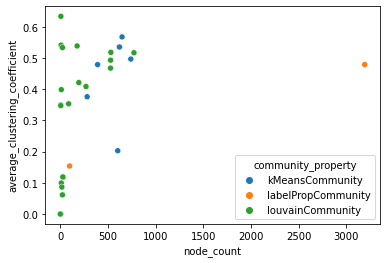

In [40]:
sns.scatterplot(x="node_count", y="average_clustering_coefficient", hue="community_property", data=community_df)

# What is a good example of a member of each cluster?

Write a function that applies a centrality score to a subgraph and gets back the top few airports IDs.

In [41]:
def get_most_central_airports(subgraph):
    subgraph_name = subgraph.name()
    top_airport_df = gds.run_cypher("""
    call gds.degree.stream($subgraphName) yield nodeId, score
    WITH gds.util.asNode(nodeId) as a, score
    ORDER BY score desc
    LIMIT 3
    RETURN collect(a.descr) as airportDescription
    """, {"subgraphName": subgraph_name})
    return top_airport_df.loc[0, "airportDescription"]

In [42]:
community_df['example_airports'] = community_df['subgraph'].map(get_most_central_airports)

In [43]:
community_df

,community_property,community,node_count,subgraph,conductance,average_clustering_coefficient,example_airports
0,kMeansCommunity,0,283,<graphdatascience.graph.graph_object.Graph obj...,0.221711,0.376070,"[Sao Paulo, Guarulhos - Governador Andras Fran..."
1,kMeansCommunity,1,604,<graphdatascience.graph.graph_object.Graph obj...,0.307613,0.202911,"[Brisbane International Airport, Auckland Inte..."
2,kMeansCommunity,2,393,<graphdatascience.graph.graph_object.Graph obj...,0.340567,0.479081,"[Dubai International Airport, Johannesburg, OR..."
3,kMeansCommunity,3,622,<graphdatascience.graph.graph_object.Graph obj...,0.150480,0.535675,"[Beijing Capital International Airport, Shangh..."
4,kMeansCommunity,4,649,<graphdatascience.graph.graph_object.Graph obj...,0.116055,0.567970,"[Dallas/Fort Worth International Airport, Chic..."
5,kMeansCommunity,5,741,<graphdatascience.graph.graph_object.Graph obj...,0.103215,0.496894,"[Munich International Airport, London Stansted..."
6,labelPropCommunity,8629,3193,<graphdatascience.graph.graph_object.Graph obj...,0.000443,0.479254,"[Frankfurt am Main, Paris Charles de Gaulle, I..."
7,labelPropCommunity,8634,99,<graphdatascience.graph.graph_object.Graph obj...,0.123867,0.153943,"[Anchorage Ted Stevens, Bethel Airport, Nome A..."
8,louvainCommunity,65,271,<graphdatascience.graph.graph_object.Graph obj...,0.168021,0.408883,"[Sydney Kingsford Smith, Brisbane Internationa..."
9,louvainCommunity,810,178,<graphdatascience.graph.graph_object.Graph obj...,0.435606,0.538963,"[Moscow, Domodedovo International Airport, Pul..."
